<a href="https://colab.research.google.com/github/lsanarchist/ASFEnhance_test/blob/master/train_lite6_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1. Setup & Imports

In [2]:
# Install dependencies if needed
# !pip install scikit-learn pandas numpy xgboost lightgbm joblib

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             classification_report, confusion_matrix, roc_auc_score)
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
import joblib
import json
import os
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

print("✓ Libraries imported successfully!")

✓ Libraries imported successfully!


## 2. Configuration

In [4]:
# ============================================
# LITE MODEL CONFIGURATION (6 FEATURES)
# ============================================

LITE_FEATURES = [
    'temperature_water',
    'turbidity',
    'ph',
    'specific_conductance',
    'nitrate',
    'nitrite'
]

# Bacteria configurations with EPA thresholds
BACTERIA_CONFIGS = {
    'ecoli': {
        'file': 'data/ecoli_imputed_US_06_2010_2023.csv',
        'target_col': 'ecoli',
        'threshold': 126,  # EPA standard (CFU/100mL)
        'column_mapping': {
            'temp': 'temperature_water',
            'spc': 'specific_conductance',
            'do': 'dissolved_oxygen_do',
            'inorg_n': 'inorganic_nitrogen_nitrate_and_nitrite',
            'ortho_p': 'orthophosphate'
        }
    },
    'enterococcus': {
        'file': 'data/enterococcus_imputed_US_06_2010_2023.csv',
        'target_col': 'enterococcus',
        'threshold': 35,  # EPA Beach Action Value
        'column_mapping': None
    },
    'fecal_coliform': {
        'file': 'data/fecal_coliform_imputed_US_06_2010_2023.csv',
        'target_col': 'fecal_coliform',
        'threshold': 200,  # EPA recreational water standard
        'column_mapping': None
    },
    'total_coliform': {
        'file': 'data/total_coliform_imputed_US_06_2010_2023.csv',
        'target_col': 'total_coliform',
        'threshold': 1000,  # General standard
        'column_mapping': None
    }
}

# Output directory
OUTPUT_DIR = 'models_lite'
os.makedirs(OUTPUT_DIR, exist_ok=True)

print("\n" + "="*60)
print("LITE MODEL CONFIGURATION")
print("="*60)
print(f"\nFeatures ({len(LITE_FEATURES)}): {LITE_FEATURES}")
print(f"\nBacteria Types: {list(BACTERIA_CONFIGS.keys())}")
print(f"Output Directory: {OUTPUT_DIR}")


LITE MODEL CONFIGURATION

Features (6): ['temperature_water', 'turbidity', 'ph', 'specific_conductance', 'nitrate', 'nitrite']

Bacteria Types: ['ecoli', 'enterococcus', 'fecal_coliform', 'total_coliform']
Output Directory: models_lite


## 3. Data Loading & Preprocessing

In [5]:
def load_bacteria_data(config, bacteria_name):
    """
    Load and preprocess bacteria dataset.
    """
    print(f"\nLoading {bacteria_name} data...")

    # Load file
    df = pd.read_csv(config['file'])
    print(f"  Raw shape: {df.shape}")

    # Apply column mapping if needed
    if config.get('column_mapping'):
        df = df.rename(columns=config['column_mapping'])
        print(f"  Applied column mapping")

    # Create binary target
    target_col = config['target_col']
    threshold = config['threshold']
    df['is_unsafe'] = (df[target_col] > threshold).astype(int)

    # Check available features
    available_features = [f for f in LITE_FEATURES if f in df.columns]
    missing_features = set(LITE_FEATURES) - set(available_features)

    if missing_features:
        print(f"  ⚠ Missing features: {missing_features}")

    # Filter to valid rows (has target value)
    df = df.dropna(subset=[target_col])

    # Class distribution
    safe_count = (df['is_unsafe'] == 0).sum()
    unsafe_count = (df['is_unsafe'] == 1).sum()
    total = len(df)

    print(f"  Final shape: {df.shape}")
    print(f"  Class distribution: SAFE={safe_count} ({safe_count/total*100:.1f}%), UNSAFE={unsafe_count} ({unsafe_count/total*100:.1f}%)")

    return df, available_features


def prepare_training_data(df, features):
    """
    Prepare X (features) and y (target) for training.
    """
    X = df[features].copy()
    y = df['is_unsafe'].copy()

    # Fill missing values with column means
    X = X.fillna(X.mean())

    return X, y

## 4. Model Training

In [6]:
def train_lite_model(X, y, bacteria_name, optimize_recall=True):
    """
    Train the lite model using XGBoost with recall-first optimization.

    Returns: model, scaler, metrics, predictions
    """
    print(f"\n{'='*50}")
    print(f"Training {bacteria_name.upper()} Lite Model")
    print(f"{'='*50}")

    # Train/Validation/Test split
    X_train_val, X_test, y_train_val, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )
    X_train, X_val, y_train, y_val = train_test_split(
        X_train_val, y_train_val, test_size=0.25, random_state=42, stratify=y_train_val
    )

    print(f"Train: {len(X_train)}, Val: {len(X_val)}, Test: {len(X_test)}")

    # Calculate class imbalance
    n_safe = (y_train == 0).sum()
    n_unsafe = (y_train == 1).sum()

    # RECALL-FIRST: Higher weight for UNSAFE class
    scale_weight = (n_safe / n_unsafe) * (2.0 if optimize_recall else 1.0)

    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    X_test_scaled = scaler.transform(X_test)

    # Train XGBoost
    model = XGBClassifier(
        n_estimators=100,
        max_depth=4,
        learning_rate=0.1,
        random_state=42,
        verbosity=0,
        scale_pos_weight=scale_weight
    )

    model.fit(X_train_scaled, y_train)

    # Predict with recall-first threshold
    y_test_proba = model.predict_proba(X_test_scaled)[:, 1]
    recall_threshold = 0.3 if optimize_recall else 0.5
    y_test_pred = (y_test_proba >= recall_threshold).astype(int)

    # Calculate metrics
    metrics = {
        'accuracy': accuracy_score(y_test, y_test_pred),
        'precision': precision_score(y_test, y_test_pred, zero_division=0),
        'recall': recall_score(y_test, y_test_pred, zero_division=0),
        'f1': f1_score(y_test, y_test_pred, zero_division=0),
        'roc_auc': roc_auc_score(y_test, y_test_proba),
        'threshold': recall_threshold
    }

    print(f"\nTest Results:")
    print(f"  Accuracy:  {metrics['accuracy']:.4f}")
    print(f"  Precision: {metrics['precision']:.4f}")
    print(f"  Recall:    {metrics['recall']:.4f} ⭐")
    print(f"  F1:        {metrics['f1']:.4f}")
    print(f"  ROC-AUC:   {metrics['roc_auc']:.4f}")

    # Cross-validation
    cv_scores = cross_val_score(
        model, scaler.transform(X), y,
        cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
        scoring='f1'
    )
    print(f"\n5-Fold CV F1: {cv_scores.mean():.4f} (+/- {cv_scores.std()*2:.4f})")

    return model, scaler, metrics, (y_test, y_test_pred, y_test_proba)

## 5. Train All Bacteria Models

In [7]:
# Store all trained models
trained_models = {}

print("="*70)
print("TRAINING LITE MODELS FOR ALL BACTERIA TYPES")
print(f"Features: {LITE_FEATURES}")
print("="*70)

for bacteria_name, config in BACTERIA_CONFIGS.items():
    try:
        # Check if file exists
        if not os.path.exists(config['file']):
            print(f"\n⚠ Skipping {bacteria_name}: file not found ({config['file']})")
            continue

        # Load data
        df, available_features = load_bacteria_data(config, bacteria_name)

        # Check if we have enough features
        if len(available_features) < 3:
            print(f"  ⚠ Skipping: not enough features ({len(available_features)})")
            continue

        # Prepare data
        X, y = prepare_training_data(df, available_features)

        # Train model
        model, scaler, metrics, predictions = train_lite_model(
            X, y, bacteria_name, optimize_recall=True
        )

        # Store results
        trained_models[bacteria_name] = {
            'model': model,
            'scaler': scaler,
            'metrics': metrics,
            'features': available_features,
            'threshold': config['threshold'],
            'predictions': predictions
        }

        print(f"\n✓ {bacteria_name} model trained successfully!")

    except Exception as e:
        print(f"\n✗ Error training {bacteria_name}: {e}")

print(f"\n{'='*70}")
print(f"TRAINING COMPLETE: {len(trained_models)}/{len(BACTERIA_CONFIGS)} models trained")
print(f"{'='*70}")

TRAINING LITE MODELS FOR ALL BACTERIA TYPES
Features: ['temperature_water', 'turbidity', 'ph', 'specific_conductance', 'nitrate', 'nitrite']

Loading ecoli data...
  Raw shape: (6382, 16)
  Applied column mapping
  Final shape: (6382, 17)
  Class distribution: SAFE=4255 (66.7%), UNSAFE=2127 (33.3%)

Training ECOLI Lite Model
Train: 3828, Val: 1277, Test: 1277

Test Results:
  Accuracy:  0.5474
  Precision: 0.4224
  Recall:    0.9718 ⭐
  F1:        0.5889
  ROC-AUC:   0.8153

5-Fold CV F1: 0.6228 (+/- 0.0098)

✓ ecoli model trained successfully!

Loading enterococcus data...
  Raw shape: (747, 16)
  Final shape: (747, 17)
  Class distribution: SAFE=171 (22.9%), UNSAFE=576 (77.1%)

Training ENTEROCOCCUS Lite Model
Train: 447, Val: 150, Test: 150

Test Results:
  Accuracy:  0.8867
  Precision: 0.8898
  Recall:    0.9741 ⭐
  F1:        0.9300
  ROC-AUC:   0.9244

5-Fold CV F1: 0.9287 (+/- 0.0304)

✓ enterococcus model trained successfully!

Loading fecal_coliform data...
  Raw shape: (1257

## 6. Visualization

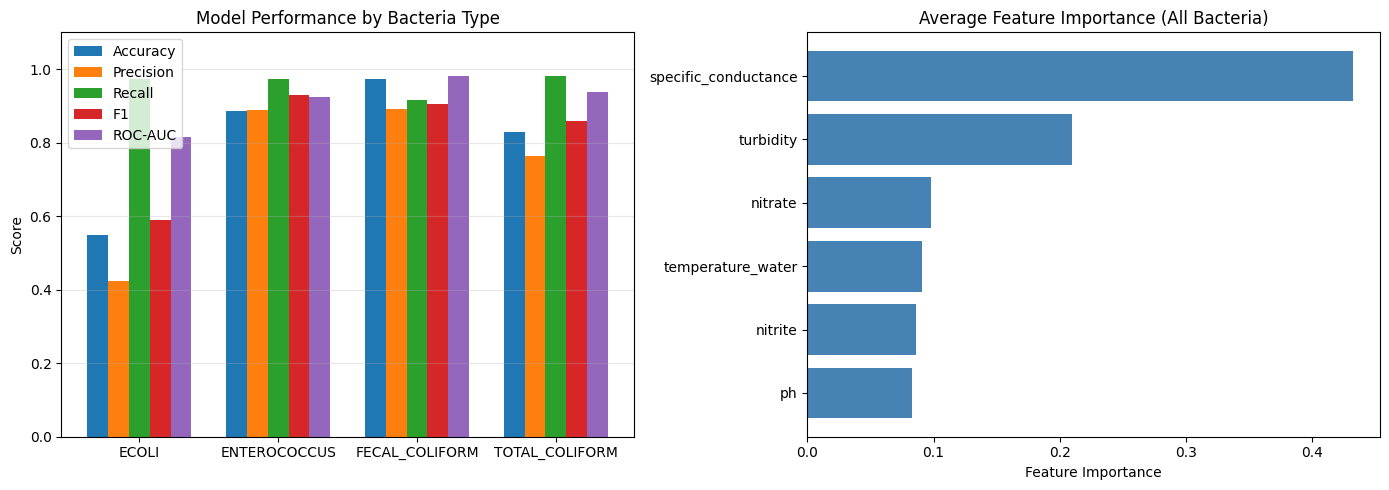


✓ Saved: models_lite/model_performance.png


In [8]:
# Plot results comparison
if trained_models:
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    bacteria_names = list(trained_models.keys())

    # Metrics comparison
    metrics_data = {
        'Accuracy': [trained_models[b]['metrics']['accuracy'] for b in bacteria_names],
        'Precision': [trained_models[b]['metrics']['precision'] for b in bacteria_names],
        'Recall': [trained_models[b]['metrics']['recall'] for b in bacteria_names],
        'F1': [trained_models[b]['metrics']['f1'] for b in bacteria_names],
        'ROC-AUC': [trained_models[b]['metrics']['roc_auc'] for b in bacteria_names]
    }

    x = np.arange(len(bacteria_names))
    width = 0.15

    for i, (metric, values) in enumerate(metrics_data.items()):
        axes[0].bar(x + i*width, values, width, label=metric)

    axes[0].set_ylabel('Score')
    axes[0].set_title('Model Performance by Bacteria Type')
    axes[0].set_xticks(x + width * 2)
    axes[0].set_xticklabels([b.upper() for b in bacteria_names])
    axes[0].legend()
    axes[0].set_ylim(0, 1.1)
    axes[0].grid(axis='y', alpha=0.3)

    # Average feature importance across all models
    if bacteria_names:
        all_importances = {}
        for bacteria_name in bacteria_names:
            model_data = trained_models[bacteria_name]
            features = model_data['features']
            importance = model_data['model'].feature_importances_
            for f, imp in zip(features, importance):
                if f not in all_importances:
                    all_importances[f] = []
                all_importances[f].append(imp)

        # Calculate mean importance
        avg_importance = {f: np.mean(imps) for f, imps in all_importances.items()}
        sorted_features = sorted(avg_importance.keys(), key=lambda x: avg_importance[x])

        axes[1].barh(sorted_features, [avg_importance[f] for f in sorted_features], color='steelblue')
        axes[1].set_xlabel('Feature Importance')
        axes[1].set_title('Average Feature Importance (All Bacteria)')

    plt.tight_layout()
    plt.savefig(f'{OUTPUT_DIR}/model_performance.png', dpi=150, bbox_inches='tight')
    plt.show()
    print(f"\n✓ Saved: {OUTPUT_DIR}/model_performance.png")

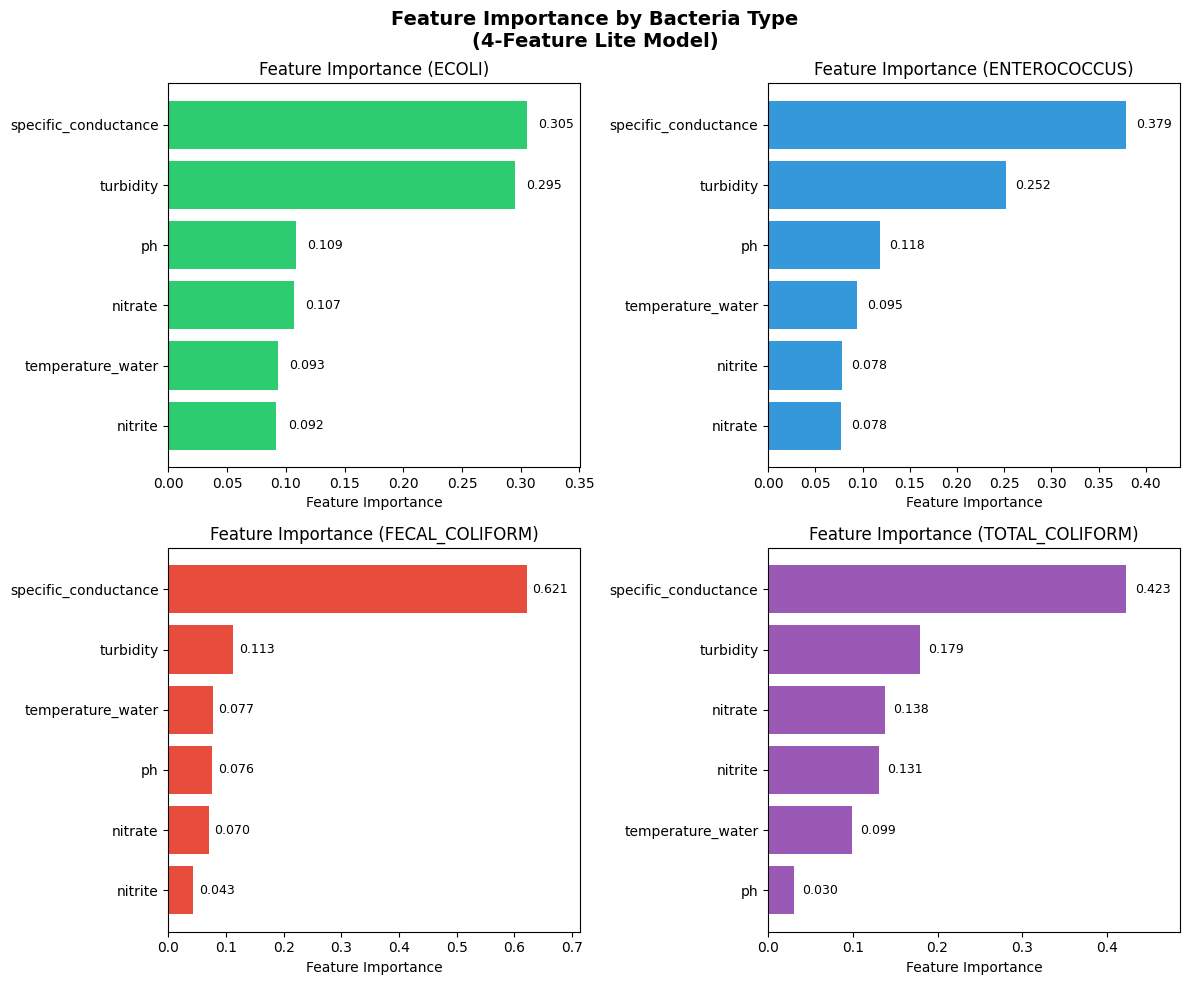


✓ Saved: models_lite/feature_importance_all.png

FEATURE IMPORTANCE SUMMARY

Feature                   |    ECOLI     | ENTEROCOCCUS | FECAL_COLIFORM | TOTAL_COLIFORM
----------------------------------------------------------------------
nitrate                   |    0.1067    |    0.0776    |    0.0699    |    0.1379    |
nitrite                   |    0.0919    |    0.0783    |    0.0431    |    0.1306    |
ph                        |    0.1086    |    0.1183    |    0.0759    |    0.0302    |
specific_conductance      |    0.3049    |    0.3794    |    0.6213    |    0.4228    |
temperature_water         |    0.0932    |    0.0945    |    0.0769    |    0.0992    |
turbidity                 |    0.2948    |    0.2519    |    0.1128    |    0.1794    |


In [9]:
# Feature importance for ALL 4 bacteria types
if trained_models:
    n_bacteria = len(trained_models)
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    axes = axes.flatten()

    colors = ['#2ecc71', '#3498db', '#e74c3c', '#9b59b6']

    for idx, (bacteria_name, data) in enumerate(trained_models.items()):
        if idx >= 4:
            break

        features = data['features']
        importance = data['model'].feature_importances_

        # Sort by importance
        sorted_idx = np.argsort(importance)
        sorted_features = [features[i] for i in sorted_idx]
        sorted_importance = importance[sorted_idx]

        # Plot
        bars = axes[idx].barh(sorted_features, sorted_importance, color=colors[idx % len(colors)])
        axes[idx].set_xlabel('Feature Importance')
        axes[idx].set_title(f'Feature Importance ({bacteria_name.upper()})')
        axes[idx].set_xlim(0, max(sorted_importance) * 1.15)

        # Add value labels
        for bar, val in zip(bars, sorted_importance):
            axes[idx].text(val + 0.01, bar.get_y() + bar.get_height()/2,
                          f'{val:.3f}', va='center', fontsize=9)

    # Hide unused subplots
    for idx in range(len(trained_models), 4):
        axes[idx].axis('off')

    plt.suptitle('Feature Importance by Bacteria Type\n(4-Feature Lite Model)', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.savefig(f'{OUTPUT_DIR}/feature_importance_all.png', dpi=150, bbox_inches='tight')
    plt.show()
    print(f"\n✓ Saved: {OUTPUT_DIR}/feature_importance_all.png")

    # Print summary table
    print("\n" + "="*70)
    print("FEATURE IMPORTANCE SUMMARY")
    print("="*70)
    print(f"\n{'Feature':<25} | " + " | ".join([f'{b.upper():^12}' for b in trained_models.keys()]))
    print("-" * 70)

    # Gather all features
    all_features = set()
    for data in trained_models.values():
        all_features.update(data['features'])

    for feature in sorted(all_features):
        row = f"{feature:<25} |"
        for bacteria_name, data in trained_models.items():
            if feature in data['features']:
                idx = data['features'].index(feature)
                imp = data['model'].feature_importances_[idx]
                row += f" {imp:^12.4f} |"
            else:
                row += f" {'N/A':^12} |"
        print(row)

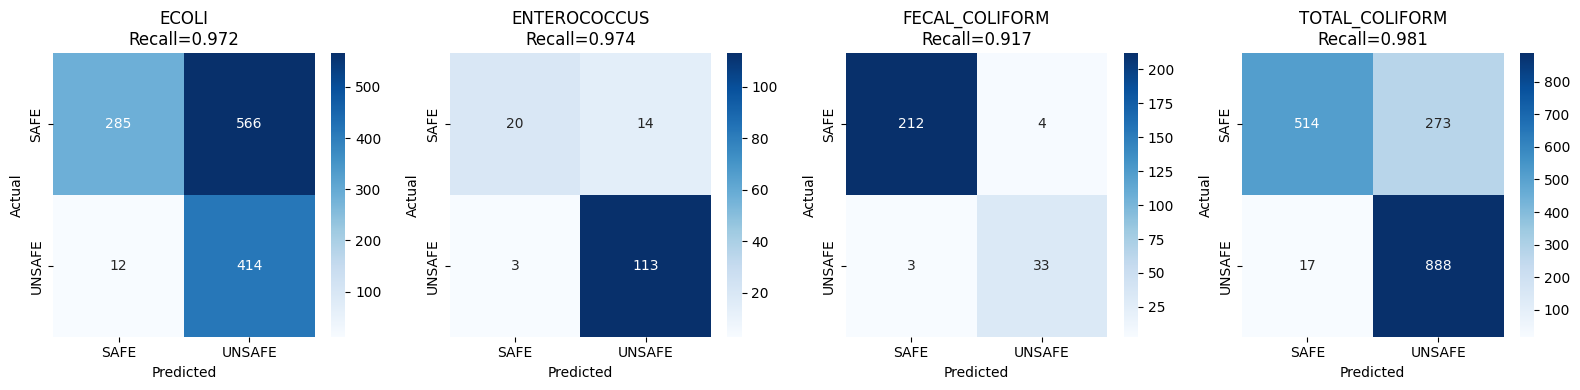


✓ Saved: models_lite/confusion_matrices.png


In [10]:
# Confusion matrices
if trained_models:
    n_models = len(trained_models)
    fig, axes = plt.subplots(1, min(n_models, 4), figsize=(4*min(n_models, 4), 4))
    if n_models == 1:
        axes = [axes]

    for idx, (bacteria_name, data) in enumerate(trained_models.items()):
        if idx >= 4:
            break

        y_test, y_pred, _ = data['predictions']
        cm = confusion_matrix(y_test, y_pred)

        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[idx],
                    xticklabels=['SAFE', 'UNSAFE'], yticklabels=['SAFE', 'UNSAFE'])
        axes[idx].set_xlabel('Predicted')
        axes[idx].set_ylabel('Actual')
        axes[idx].set_title(f'{bacteria_name.upper()}\nRecall={data["metrics"]["recall"]:.3f}')

    plt.tight_layout()
    plt.savefig(f'{OUTPUT_DIR}/confusion_matrices.png', dpi=150, bbox_inches='tight')
    plt.show()
    print(f"\n✓ Saved: {OUTPUT_DIR}/confusion_matrices.png")

## 7. Export Models for Production

In [12]:
def export_lite_models(trained_models, output_dir):
    """
    Export all trained models for production deployment.
    """
    os.makedirs(output_dir, exist_ok=True)

    # Create manifest
    manifest = {
        'export_date': datetime.now().isoformat(),
        'model_type': 'lite_4_features',
        'features': LITE_FEATURES,
        'optimization': 'recall-first',
        'models': {},
        'bacteria_thresholds': {}
    }

    for bacteria_name, data in trained_models.items():
        # Save model
        model_file = f'{bacteria_name}_lite_model.joblib'
        joblib.dump(data['model'], os.path.join(output_dir, model_file))

        # Save scaler
        scaler_file = f'{bacteria_name}_lite_scaler.joblib'
        joblib.dump(data['scaler'], os.path.join(output_dir, scaler_file))

        # Add to manifest
        manifest['models'][bacteria_name] = {
            'model_file': model_file,
            'scaler_file': scaler_file,
            'features': data['features'],
            'metrics': {
                'accuracy': float(data['metrics']['accuracy']),
                'precision': float(data['metrics']['precision']),
                'recall': float(data['metrics']['recall']),
                'f1': float(data['metrics']['f1']),
                'roc_auc': float(data['metrics']['roc_auc'])
            },
            'prediction_threshold': float(data['metrics']['threshold'])
        }
        manifest['bacteria_thresholds'][bacteria_name] = data['threshold']

        print(f"✓ Exported: {model_file}, {scaler_file}")

    # Save manifest
    manifest_path = os.path.join(output_dir, 'manifest.json')
    with open(manifest_path, 'w') as f:
        json.dump(manifest, f, indent=2)
    print(f"✓ Saved manifest: {manifest_path}")

    return manifest


# Export models
if trained_models:
    print("\n" + "="*70)
    print("EXPORTING LITE MODELS")
    print("="*70 + "\n")

    manifest = export_lite_models(trained_models, OUTPUT_DIR)

    print(f"\n✓ All models exported to: {OUTPUT_DIR}/")
else:
    print("⚠ No models to export")


EXPORTING LITE MODELS

✓ Exported: ecoli_lite_model.joblib, ecoli_lite_scaler.joblib
✓ Exported: enterococcus_lite_model.joblib, enterococcus_lite_scaler.joblib
✓ Exported: fecal_coliform_lite_model.joblib, fecal_coliform_lite_scaler.joblib
✓ Exported: total_coliform_lite_model.joblib, total_coliform_lite_scaler.joblib
✓ Saved manifest: models_lite/manifest.json

✓ All models exported to: models_lite/


## 8. Generate Production Files

In [15]:
# Generate inference.py
inference_code = '''#!/usr/bin/env python3
"""
Water Safety Lite Model - Production Inference
6-Feature Model: temperature_water, turbidity, ph, specific_conductance, nitrate, nitrite

Usage:
    python inference.py --bacteria ecoli --temp 22 --turbidity 5 --ph 7.5 --conductance 400 --nitrate 1.0 --nitrite 0.1

    Or as module:
    from inference import LitePredictor
    predictor = LitePredictor('ecoli')
    result = predictor.predict({'temperature_water': 22, 'turbidity': 5, 'ph': 7.5, 'specific_conductance': 400, 'nitrate': 1.0, 'nitrite': 0.1})
"""

import warnings
warnings.filterwarnings('ignore')

import joblib
import json
import numpy as np
import os
import argparse


class LitePredictor:
    """Lite water safety predictor using 6 features."""

    FEATURES = ['temperature_water', 'turbidity', 'ph', 'specific_conductance', 'nitrate', 'nitrite']

    def __init__(self, bacteria_type='ecoli', models_dir=None):
        """
        Initialize predictor.

        Args:
            bacteria_type: 'ecoli', 'enterococcus', 'fecal_coliform', or 'total_coliform'
            models_dir: Directory with models (default: same as script)
        """
        self.bacteria_type = bacteria_type

        if models_dir is None:
            models_dir = os.path.dirname(os.path.abspath(__file__))
        self.models_dir = models_dir

        # Load manifest
        manifest_path = os.path.join(models_dir, 'manifest.json')
        with open(manifest_path, 'r') as f:
            self.manifest = json.load(f)

        # Get model config
        if bacteria_type not in self.manifest['models']:
            raise ValueError(f"Unknown bacteria type: {bacteria_type}. Available: {list(self.manifest['models'].keys())}")

        config = self.manifest['models'][bacteria_type]

        # Load model and scaler
        self.model = joblib.load(os.path.join(models_dir, config['model_file']))
        self.scaler = joblib.load(os.path.join(models_dir, config['scaler_file']))
        self.features = config['features']
        self.prediction_threshold = config['prediction_threshold']
        self.bacteria_threshold = self.manifest['bacteria_thresholds'][bacteria_type]

    def predict(self, measurements: dict) -> dict:
        """
        Predict water safety.

        Args:
            measurements: Dict with feature values
                {'temperature_water': 22.0, 'turbidity': 5.0, 'ph': 7.5, 'specific_conductance': 400}

        Returns:
            Dict with prediction results
        """
        # Create feature array
        X = np.array([[measurements.get(f, 0) for f in self.features]])

        # Scale and predict
        X_scaled = self.scaler.transform(X)
        proba = self.model.predict_proba(X_scaled)[0][1]

        # Apply threshold
        is_unsafe = proba >= self.prediction_threshold

        return {
            'prediction': 'UNSAFE' if is_unsafe else 'SAFE',
            'probability_unsafe': float(proba),
            'confidence': float(max(proba, 1 - proba)),
            'bacteria_type': self.bacteria_type,
            'epa_threshold': self.bacteria_threshold,
            'measurements': measurements
        }

    def predict_batch(self, samples: list) -> list:
        """Predict for multiple samples."""
        return [self.predict(s) for s in samples]


class MultiPredictor:
    """Predict all bacteria types at once."""

    BACTERIA_NAMES = {
        'ecoli': 'E. coli',
        'enterococcus': 'Enterococcus',
        'fecal_coliform': 'Fecal Coliform',
        'total_coliform': 'Total Coliform'
    }

    def __init__(self, models_dir=None):
        self.predictors = {}
        for bacteria in self.BACTERIA_NAMES.keys():
            try:
                self.predictors[bacteria] = LitePredictor(bacteria, models_dir)
            except Exception as e:
                print(f"Warning: Could not load {bacteria}: {e}")

    def predict(self, measurements: dict) -> dict:
        """Predict all bacteria types."""
        results = {
            'measurements': measurements,
            'predictions': {},
            'unsafe_bacteria': [],
            'overall': 'SAFE'
        }

        for bacteria, predictor in self.predictors.items():
            pred = predictor.predict(measurements)
            results['predictions'][bacteria] = pred
            if pred['prediction'] == 'UNSAFE':
                results['unsafe_bacteria'].append(self.BACTERIA_NAMES[bacteria])

        if results['unsafe_bacteria']:
            results['overall'] = 'UNSAFE'
            results['reason'] = f"Unsafe due to: {', '.join(results['unsafe_bacteria'])}"
        else:
            results['reason'] = 'All bacteria within safe limits'

        return results


def main():
    parser = argparse.ArgumentParser(description='Water Safety Lite Prediction')
    parser.add_argument('--bacteria', type=str, default='ecoli',
                        choices=['ecoli', 'enterococcus', 'fecal_coliform', 'total_coliform'],
                        help='Bacteria type')
    parser.add_argument('--temp', type=float, required=True, help='Water temperature (°C)')
    parser.add_argument('--turbidity', type=float, required=True, help='Turbidity (NTU)')
    parser.add_argument('--ph', type=float, required=True, help='pH level')
    parser.add_argument('--conductance', type=float, required=True, help='Specific conductance (µS/cm)')
    parser.add_argument('--nitrate', type=float, default=0.0, help='Nitrate (mg/L)')
    parser.add_argument('--nitrite', type=float, default=0.0, help='Nitrite (mg/L)')
    parser.add_argument('--all', action='store_true', help='Predict all bacteria types')

    args = parser.parse_args()

    measurements = {
        'temperature_water': args.temp,
        'turbidity': args.turbidity,
        'ph': args.ph,
        'specific_conductance': args.conductance,
        'nitrate': args.nitrate,
        'nitrite': args.nitrite
    }

    if args.all:
        predictor = MultiPredictor()
        result = predictor.predict(measurements)
        print(f"\\n{'='*50}")
        print(f"OVERALL: {result['overall']}")
        print(f"Reason: {result['reason']}")
        print(f"{'='*50}")
    else:
        predictor = LitePredictor(args.bacteria)
        result = predictor.predict(measurements)
        print(f"\\n{'='*50}")
        print(f"🔮 {args.bacteria.upper()}: {result['prediction']}")
        print(f"   Probability: {result['probability_unsafe']*100:.1f}%")
        print(f"{'='*50}")


if __name__ == '__main__':
    main()
'''

# Save inference.py

inference_path = os.path.join(OUTPUT_DIR, 'inference.py')
print(f"✓ Generated: {inference_path}")

with open(inference_path, 'w') as f:    f.write(inference_code)

✓ Generated: models_lite/inference.py


In [17]:
# Generate api.py (FastAPI)
api_code = '''#!/usr/bin/env python3
"""
Water Safety Lite API
FastAPI server for production deployment.

Run: uvicorn api:app --host 0.0.0.0 --port 8000
"""

from fastapi import FastAPI, HTTPException
from pydantic import BaseModel, Field
from typing import Optional, Dict, Any, List
from inference import LitePredictor, MultiPredictor
import os

# Get models directory
MODELS_DIR = os.path.dirname(os.path.abspath(__file__))

app = FastAPI(
    title="Water Safety Lite API",
    description="Predict bacteria contamination using 6 water quality parameters",
    version="2.0.0"
)

# Load predictors
predictors = {}
for bacteria in ['ecoli', 'enterococcus', 'fecal_coliform', 'total_coliform']:
    try:
        predictors[bacteria] = LitePredictor(bacteria, MODELS_DIR)
        print(f"✓ Loaded {bacteria} model")
    except Exception as e:
        print(f"⚠ Could not load {bacteria}: {e}")

multi_predictor = MultiPredictor(MODELS_DIR) if predictors else None


class LiteMeasurement(BaseModel):
    """6-feature water measurement input."""
    temperature_water: float = Field(..., description="Water temperature (°C)", ge=-5, le=50)
    turbidity: float = Field(..., description="Turbidity (NTU)", ge=0)
    ph: float = Field(..., description="pH level", ge=0, le=14)
    specific_conductance: float = Field(..., description="Specific conductance (µS/cm)", ge=0)
    nitrate: float = Field(0.0, description="Nitrate (mg/L)", ge=0)
    nitrite: float = Field(0.0, description="Nitrite (mg/L)", ge=0)


class PredictionResult(BaseModel):
    prediction: str
    probability_unsafe: float
    confidence: float
    bacteria_type: str
    epa_threshold: int


@app.get("/")
def root():
    return {
        "features": ["temperature_water", "turbidity", "ph", "specific_conductance", "nitrate", "nitrite"],
        "version": "2.0.0",
        "features": ["temperature_water", "turbidity", "ph", "specific_conductance"],
        "available_bacteria": list(predictors.keys()),
        "endpoints": {
            "/predict/{bacteria}": "POST - Predict single bacteria",
            "/predict_all": "POST - Predict all bacteria types",
            "/health": "GET - Health check"
        }
    }


@app.get("/health")
def health():
    return {
        "status": "healthy",
        "models_loaded": list(predictors.keys()),
        "model_count": len(predictors)
    }


@app.post("/predict/{bacteria}", response_model=PredictionResult)
def predict(bacteria: str, measurements: LiteMeasurement):
    """
    Predict water safety for a specific bacteria type.

    - **bacteria**: ecoli, enterococcus, fecal_coliform, or total_coliform
    - **measurements**: Water quality measurements (4 required features)
    """
    if bacteria not in predictors:
        raise HTTPException(404, f"Model not found: {bacteria}. Available: {list(predictors.keys())}")

    result = predictors[bacteria].predict(measurements.model_dump())

    return PredictionResult(
        prediction=result['prediction'],
        probability_unsafe=result['probability_unsafe'],
        confidence=result['confidence'],
        bacteria_type=result['bacteria_type'],
        epa_threshold=result['epa_threshold']
    )


@app.post("/predict_all")
def predict_all(measurements: LiteMeasurement) -> Dict[str, Any]:
    """
    Predict water safety for ALL bacteria types at once.
    Returns overall assessment and breakdown by bacteria.
    """
    if not multi_predictor:
        raise HTTPException(500, "No models loaded")

    result = multi_predictor.predict(measurements.model_dump())

    return {
        "overall_prediction": result['overall'],
        "reason": result['reason'],
        "unsafe_bacteria": result['unsafe_bacteria'],
        "measurements": result['measurements'],
        "bacteria_predictions": {
            k: {
                "prediction": v['prediction'],
                "probability": v['probability_unsafe'],
                "epa_threshold": v['epa_threshold']
            }
            for k, v in result['predictions'].items()
        }
    }


if __name__ == "__main__":
    import uvicorn
    uvicorn.run(app, host="0.0.0.0", port=8000)
'''

api_path = os.path.join(OUTPUT_DIR, 'api.py')
with open(api_path, 'w') as f:

    f.write(api_code)
    print(f"✓ Generated: {api_path}")

✓ Generated: models_lite/api.py


In [18]:
# Generate requirements.txt
requirements = """# Water Safety Lite Model - Production Requirements
numpy>=1.21.0
pandas>=1.3.0
scikit-learn>=1.0.0
xgboost>=1.5.0
joblib>=1.1.0
fastapi>=0.100.0
uvicorn>=0.22.0
pydantic>=2.0.0
"""

req_path = os.path.join(OUTPUT_DIR, 'requirements.txt')
with open(req_path, 'w') as f:
    f.write(requirements)
print(f"✓ Generated: {req_path}")

✓ Generated: models_lite/requirements.txt


In [ ]:
# Generate Dockerfile
dockerfile = """# Water Safety Lite API - Production Dockerfile
FROM python:3.11-slim

# Set working directory
WORKDIR /app

# Install dependencies
COPY requirements.txt .
RUN pip install --no-cache-dir -r requirements.txt

# Copy application files
COPY . .

# Expose port
EXPOSE 8000

# Health check
HEALTHCHECK --interval=30s --timeout=10s --start-period=5s --retries=3 \\
    CMD curl -f http://localhost:8000/health || exit 1

# Run server
CMD ["uvicorn", "api:app", "--host", "0.0.0.0", "--port", "8000"]
"""

dockerfile_path = os.path.join(OUTPUT_DIR, 'Dockerfile')
with open(dockerfile_path, 'w') as f:
    f.write(dockerfile)
print(f"✓ Generated: {dockerfile_path}")

In [ ]:
# Generate docker-compose.yml
docker_compose = """# Water Safety Lite API - Docker Compose
version: '3.8'

services:
  water-safety-api:
    build: .
    ports:
      - "8000:8000"
    environment:
      - PYTHONUNBUFFERED=1
    restart: unless-stopped
    healthcheck:
      test: ["CMD", "curl", "-f", "http://localhost:8000/health"]
      interval: 30s
      timeout: 10s
      retries: 3
      start_period: 10s
"""

compose_path = os.path.join(OUTPUT_DIR, 'docker-compose.yml')
with open(compose_path, 'w') as f:
    f.write(docker_compose)
print(f"✓ Generated: {compose_path}")

## 9. Summary & Deployment Instructions

In [19]:
# Print summary
print("\n" + "="*70)
print("🚀 LITE MODEL TRAINING COMPLETE")
print("="*70)

print(f"\n📁 Output Directory: {OUTPUT_DIR}/")
print(f"\n📊 Features ({len(LITE_FEATURES)}):")
for f in LITE_FEATURES:
    print(f"   • {f}")

print(f"\n🦠 Trained Models:")
for bacteria, data in trained_models.items():
    m = data['metrics']
    print(f"   {bacteria}: Recall={m['recall']:.3f}, F1={m['f1']:.3f}, AUC={m['roc_auc']:.3f}")

print(f"\n📦 Files Generated:")
for f in sorted(os.listdir(OUTPUT_DIR)):
    size = os.path.getsize(os.path.join(OUTPUT_DIR, f))
    print(f"   {f:40} {size/1024:.1f} KB")

print(f"""
\n{'='*70}
🚀 DEPLOYMENT INSTRUCTIONS
{'='*70}

1. LOCAL CLI:
   cd {OUTPUT_DIR}
   pip install -r requirements.txt
   python inference.py --bacteria ecoli --temp 22 --turbidity 5 --ph 7.5 --conductance 400

2. LOCAL API:
   cd {OUTPUT_DIR}
   uvicorn api:app --reload
   # Open: http://localhost:8000/docs

3. DOCKER:
   cd {OUTPUT_DIR}
   docker build -t water-safety-lite .
   docker run -p 8000:8000 water-safety-lite

4. DOCKER COMPOSE:
   cd {OUTPUT_DIR}
   docker-compose up -d

API ENDPOINTS:
   POST /predict/ecoli          - Single bacteria prediction
   POST /predict_all            - All bacteria at once
   GET  /health                 - Health check
   GET  /docs                   - Interactive API docs
""")


🚀 LITE MODEL TRAINING COMPLETE

📁 Output Directory: models_lite/

📊 Features (6):
   • temperature_water
   • turbidity
   • ph
   • specific_conductance
   • nitrate
   • nitrite

🦠 Trained Models:
   ecoli: Recall=0.972, F1=0.589, AUC=0.815
   enterococcus: Recall=0.974, F1=0.930, AUC=0.924
   fecal_coliform: Recall=0.917, F1=0.904, AUC=0.981
   total_coliform: Recall=0.981, F1=0.860, AUC=0.938

📦 Files Generated:
   api.py                                   4.1 KB
   confusion_matrices.png                   74.3 KB
   ecoli_lite_model.joblib                  159.1 KB
   ecoli_lite_scaler.joblib                 1.1 KB
   enterococcus_lite_model.joblib           127.0 KB
   enterococcus_lite_scaler.joblib          1.1 KB
   feature_importance_all.png               125.6 KB
   fecal_coliform_lite_model.joblib         121.1 KB
   fecal_coliform_lite_scaler.joblib        1.1 KB
   inference.py                             6.5 KB
   manifest.json                            2.5 KB
   model_

In [20]:
import os
import zipfile

output_zip_file = f'{OUTPUT_DIR}.zip'

with zipfile.ZipFile(output_zip_file, 'w', zipfile.ZIP_DEFLATED) as zipf:
    for root, dirs, files in os.walk(OUTPUT_DIR):
        for file in files:
            file_path = os.path.join(root, file)
            arcname = os.path.relpath(file_path, OUTPUT_DIR)
            zipf.write(file_path, arcname)

print(f"✓ Successfully zipped '{OUTPUT_DIR}' to '{output_zip_file}'")

✓ Successfully zipped 'models_lite' to 'models_lite.zip'
